## ROI selection reconstruction into a mask

From the nicely formatted \_ROI.csv and \_emb.csv files, we want to create an image mask of the same number of pixels as the source image, which will be our mask.
The files are stored zipped, with names:

Session1_flushed_1-fs-07_emb

Session1_flushed_1-fs-07_ROI

etc. We'll open each one and create a mask for embolism and a mask for ROI, with 1 where the area is ROI or embolism, and 0 is nothing.

In [2]:
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import zipfile

In [3]:
analysis_overview_df = pd.read_csv("./th_sampledata/analysis_overview_df_with_pathnames.csv")

In [4]:
analysis_overview_df

,Unnamed: 0,plant_name,scan_nb,image_nb,voxel_size,session,pathname
0,0,1-fs-08,living,750,0.007005,Session1,/Volumes/PERL/invites/Session1/Living_plants/A...
1,1,1-fs-09,living,749,0.007005,Session1,/Volumes/PERL/invites/Session1/Living_plants/A...
2,2,1-fs-10,living,765,0.007005,Session1,/Volumes/PERL/invites/Session1/Living_plants/A...
3,3,1-fs-11,living,764,0.007005,Session1,/Volumes/PERL/invites/Session1/Living_plants/A...
4,4,1-fs-12,living,740,0.007005,Session1,/Volumes/PERL/invites/Session1/Living_plants/A...
...,...,...,...,...,...,...,...
352,352,6-qi-17,flushed,799,0.004705,Session2,/Volumes/PERL/invites/Session2/Flushed_samples...
353,353,6-qi-18,flushed,799,0.003388,Session2,/Volumes/PERL/invites/Session2/Flushed_samples...
354,354,6-qp-13,flushed,798,0.005165,Session2,/Volumes/PERL/invites/Session2/Flushed_samples...
355,355,6-qp-16,flushed,798,0.004252,Session2,/Volumes/PERL/invites/Session2/Flushed_samples...


[[[  0   0   0 255]
  [  0   0   0 255]
  [  0   0   0 255]
  ...
  [  0   0   0 255]
  [  0   0   0 255]
  [  0   0   0 255]]

 [[  0   0   0 255]
  [  0   0   0 255]
  [  0   0   0 255]
  ...
  [  0   0   0 255]
  [  0   0   0 255]
  [  0   0   0 255]]

 [[  0   0   0 255]
  [  0   0   0 255]
  [  0   0   0 255]
  ...
  [  0   0   0 255]
  [  0   0   0 255]
  [  0   0   0 255]]

 ...

 [[  0   0   0 255]
  [  0   0   0 255]
  [  0   0   0 255]
  ...
  [  0   0   0 255]
  [  0   0   0 255]
  [  0   0   0 255]]

 [[  0   0   0 255]
  [  0   0   0 255]
  [  0   0   0 255]
  ...
  [  0   0   0 255]
  [  0   0   0 255]
  [  0   0   0 255]]

 [[  0   0   0 255]
  [  0   0   0 255]
  [  0   0   0 255]
  ...
  [  0   0   0 255]
  [  0   0   0 255]
  [  0   0   0 255]]]


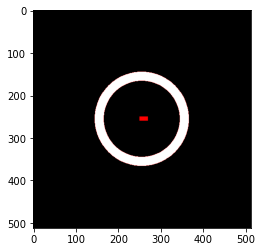

In [4]:
# We'll be working with images, so use the opencv library, with numpy to set individual values
# this works like the following, with RGBA (red green blue alpha) alpha is transparency (0 is transparent)
blank_image = np.zeros(shape=[512, 512, 4], dtype=np.uint8)
blank_image[:, :, 3] = 255
blank_image[250:260, 250:270, :3] = [255,0,0]
cv.circle(blank_image, (255, 255), 100, [255,0,0,0], 20) # only tranparency matters here, red will not show
print(blank_image)
# print(blank_image.shape)
plt.imshow(blank_image)
# cv.imwrite('test_img.png',blank_image)

In [5]:
# We need two helper functions to convert from n d array with 0 and 1, 
# to png color image, color of choice (to have good visualization possibilities)
# and also the other way around
# def mask_to_png(mask, color=[255,0,0]):
#     '''convert nd array with 0 and 1 values to png image, transparent for 0, color of choice for 1
    
#     input
#     -----
#     mask : nd array of 0 and 1 of uint8 (max 255)
#     color : optionnal, array of red green blue colors of uint8 (max 255) values [r, g, b]
    
#     output
#     ------
#     png image with transparent background and color at positions
#     '''
#     # NB opencv works with RGBA, so 4 dimensions, with A being alpha, the transparency (0=transparent)
#     npmask = np.array(mask, dtype=np.uint8)
#     npmaskr = npmask.copy()
#     npmaskr[npmask!=0] = color[0] 
#     npmaskg = npmask.copy()
#     npmaskg[npmask!=0] = color[1]
#     npmaskb = npmask.copy()
#     npmaskb[npmask!=0] = color[2]
#     npmaska = npmask.copy()
#     npmaska[npmask!=0] = 255
#     pngimage = np.stack([npmaskr,npmaskg, npmaskb, npmaska], axis=-1)
    
#     return pngimage
    
# img = mask_to_png([[1,0,0,0],[0,1,0,0],[0,0,1,0]])
# print(img)
# plt.imshow(img)
# plt.show()
# cv.imwrite('test_img.png',img)

In [6]:
# def png_to_mask(png):
#     '''convert nd array with 0 and 1 values to png image, transparent for 0, color of choice for 1
    
#     input
#     -----
#     png : 4 dimensionnal nd array of 0 and color values (or transparency) of uint8 (max 255)
    
#     output
#     ------
#     nd numpy array with 0 for background and 1 for color pixels
#     '''
#     # NB opencv works with RGBA, so 4 dimensions, with A being alpha, the transparency (0=transparent)
#     pngarray = np.array(png)
# #     print(pngarray[:,:,0])
#     mask = pngarray[:,:,3]
#     mask[mask!=0]=1
    
#     return mask

# png_to_mask([[    [255,   0,   0, 255],
#                   [  0,   0  , 0,   0],
#                   [  0 ,  0 ,  0 ,  0],
#                   [  0  , 0,   0  , 0]],
             
#             [
#                   [  0,   0   ,0,   0],
#                   [255 ,  0  , 0 ,255],
#                   [  0  , 0 ,  0  , 0],
#                   [  0   ,0,   0   ,0]],

#              [    [  0,   0   ,0,   0],
#                   [  0 ,  0  , 0 ,  0],
#                   [255  , 0 ,  0 ,255],
#                   [  0   ,0,   0  , 0]]])


In [7]:
# We'll export this to the helpers file, and re-import it here
from helpers import png_to_mask, mask_to_png

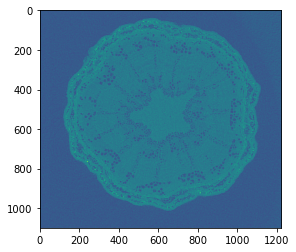

(1100, 1220)


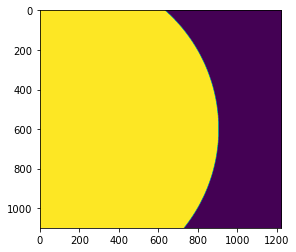

[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]


(1100, 1220)

In [8]:
# Let's see how drawing shapes in opencv works
img = cv.imread(f'./th_analysedimages/Session1_flushed_1-qp-08_752.tif', cv.IMREAD_UNCHANGED)
plt.imshow(img)
plt.show()
img_array = np.array(img)
height, width = img_array.shape
print(img_array.shape)
png_layer = np.zeros((height, width, 4))
plt.imshow(png_to_mask(png_layer))

cv.circle(png_layer, center=(100, 600), radius=800, color=(0,0,255,255), thickness=-1)

plt.imshow(png_to_mask(png_layer))
# cv.imwrite('test_img.png',png_layer)
plt.show()
print(png_to_mask(png_layer))
png_to_mask(png_layer).shape

In each \_ROI file, there is a barycenter x, y, and area for both the disk approximation of the ROI minus embolism surface and embolism surface. We know therefore that :

$$area_{ROI} = area_{ROI-emb} + area_{emb}$$

$$ x_{ROI} = x_{ROI-emb}\times \frac{area_{ROI-emb}}{area_{ROI}} + x_{emb}\times \frac{area_{emb}}{area_{ROI}}$$

$$ y_{ROI} = y_{ROI-emb}\times \frac{area_{ROI-emb}}{area_{ROI}} + y_{emb}\times \frac{area_{emb}}{area_{ROI}}$$

NB that writing $x_{emb} = x_{roi-emb} + \Delta x$ we have :

$$ x_{ROI} = x_{ROI-emb} + \Delta x \times \frac{area_{emb}}{area_{ROI}}$$

$$ y_{ROI} = y_{ROI-emb}+ \Delta y \times \frac{area_{emb}}{area_{ROI}}$$

In [9]:
# Let's finnaly do it ! Create the ROI png masks to be saved
with zipfile.ZipFile('./th_csv_labels/csv_files_emb_roi.zip') as csv_labels_folder:
    for index, row in analysis_overview_df.iterrows():
        ROI_csv_filename = f"csv_files_emb_roi/{row.session}_{row.scan_nb}_{row.plant_name}_ROI.csv"
        # print(ROI_csv_filename)
        with csv_labels_folder.open(ROI_csv_filename) as ROI_file:
            ROI_df = pd.read_csv(ROI_file, skiprows=1, index_col="index")

            emb_word = "Embolism" # Some values are misspelled
            if len(ROI_df[ROI_df.Materials=="Embolim"])!=0:
                emb_word = "Embolim"
            
            x_roi_emb = ROI_df[ROI_df.Materials=="ROI"].BaryCenterX.values[0]
            y_roi_emb = ROI_df[ROI_df.Materials=="ROI"].BaryCenterY.values[0]
            area_roi_emb = ROI_df[ROI_df.Materials=="ROI"].Area.values[0]
            
            x_emb = ROI_df[ROI_df.Materials==emb_word].BaryCenterX.values[0]
            y_emb = ROI_df[ROI_df.Materials==emb_word].BaryCenterY.values[0]
            area_emb = ROI_df[ROI_df.Materials==emb_word].Area.values[0]
            
            area_roi = area_roi_emb + area_emb
            x_roi = x_roi_emb*area_roi_emb/area_roi +  x_emb*area_emb/area_roi
            y_roi = y_roi_emb*area_roi_emb/area_roi +  y_emb*area_emb/area_roi            
            roi_radius = np.sqrt(area_roi/np.pi)
            
            # All values are in mm, need to convert to px using voxel size (mm size of pixel)
            pixel_size = row.voxel_size
            x_roi_px = int(x_roi/pixel_size)
            y_roi_px = int(y_roi/pixel_size)
            roi_radius_px = int(roi_radius/pixel_size)
                        
            # Now we'll create the label/mask for the image
            img_pathname = f'./th_analysedimages/{row.session}_{row.scan_nb}_{row.plant_name}_{row.image_nb}.tif'
            original_img = cv.imread(img_pathname, cv.IMREAD_UNCHANGED)
            img_array = np.array(original_img)
            height, width = img_array.shape
            png_layer = np.zeros((height, width, 4))
            # Draw the ROI
            cv.circle(png_layer, center=(x_roi_px, y_roi_px), radius=roi_radius_px, color=(0,0,255,100), thickness=-1)
            # Save the layer
            cv.imwrite(f'./th_csv_labels/{row.session}_{row.scan_nb}_{row.plant_name}_{row.image_nb}_mask_roi.png', png_layer)
            
#             # Save a composition of both mask and image for visual confirmation
#             img_array_uint8 = 255*((img_array-img_array.min())/(img_array.max()-img_array.min()))
#             img_rgb_bw = np.stack([img_array_uint8, img_array_uint8, img_array_uint8], axis=-1)
#             png_lay_noalpha = png_layer[:,:,:3]
#             compo = cv.addWeighted(img_rgb_bw,1,png_lay_noalpha,0.3,0)
#             cv.imwrite(f'./th_csv_labels/{row.session}_{row.scan_nb}_{row.plant_name}_{row.image_nb}_overlay.png', compo)
            
#             # For test purposes :  add both the roi_emb and _emb layers to see how they behave
#             x_roi_emb_px = int(x_roi_emb/pixel_size)
#             y_roi_emb_px = int(y_roi_emb/pixel_size)
#             radius_roi_emb_px = int(np.sqrt(area_roi_emb/np.pi)/pixel_size)
#             x_emb_px = int(x_emb/pixel_size)
#             y_emb_px = int(y_emb/pixel_size)
#             radius_emb_px = int(np.sqrt(area_emb/np.pi)/pixel_size)
#             print(index, x_roi_emb_px, y_roi_emb_px, radius_roi_emb_px)
#             print(index, x_emb_px, y_emb_px, radius_emb_px)
#             png_layer_no_alpha = np.zeros((height, width, 3))
#             cv.circle(png_layer_no_alpha, center=(x_roi_emb_px, y_roi_emb_px), radius=radius_roi_emb_px, color=(0,0,255), thickness=-1)
#             cv.circle(png_layer_no_alpha, center=(x_emb_px, y_emb_px), radius=radius_emb_px, color=(255,0,0), thickness=-1)
#             compo = cv.addWeighted(img_rgb_bw,1,png_layer_no_alpha,0.3,0)
#             cv.imwrite(f'./th_csv_labels/{row.session}_{row.scan_nb}_{row.plant_name}_{row.image_nb}_original.png', compo)

In [10]:
# And now the embolism masks,
# here seperatly going again through the whole loops, 
# could be implementedd above in the same loop for efficiency
# but it's more cluttered and it's not such a heavy task
with zipfile.ZipFile('./th_csv_labels/csv_files_emb_roi.zip') as csv_labels_folder:
    for index, row in analysis_overview_df.iterrows():
        emb_csv_filename = f"csv_files_emb_roi/{row.session}_{row.scan_nb}_{row.plant_name}_emb.csv"
        # print(emb_csv_filename)
        with csv_labels_folder.open(emb_csv_filename) as emb_file:
            emb_df = pd.read_csv(emb_file, skiprows=1, index_col="index")
#             if index<5: # See how it looks
#                 print(emb_df)
            
            # First we'll create the mask for the embolism regions
            img_pathname = f'./th_analysedimages/{row.session}_{row.scan_nb}_{row.plant_name}_{row.image_nb}.tif'
            original_img = cv.imread(img_pathname, cv.IMREAD_UNCHANGED)
            img_array = np.array(original_img)
            height, width = img_array.shape
            png_layer = np.zeros((height, width, 4))
            pixel_size = row.voxel_size
            
            # Now let's iter through all the embolism regions in the csv file
            for emb_index, emb_region in emb_df.iterrows():
#                 if emb_index < 5 and index < 5: # See how it looks
#                     print(emb_index, emb_region)
#                     print(f"emb_x={emb_region.BaryCenterX}")            
                
                x_emb = emb_region.BaryCenterX
                y_emb = emb_region.BaryCenterY
                emb_radius = emb_region.EqDiameter/2

                # All values are in mm, need to convert to px using voxel size (mm size of pixel)
                x_emb_px = int(x_emb/pixel_size)
                y_emb_px = int(y_emb/pixel_size)
                emb_radius_px = int(emb_radius/pixel_size)

                # Draw the ROI
                cv.circle(png_layer, center=(x_emb_px, y_emb_px), radius=emb_radius_px, color=(0,0,255,170), thickness=-1)
                
            # Save the layer
            cv.imwrite(f'./th_csv_labels/{row.session}_{row.scan_nb}_{row.plant_name}_{row.image_nb}_mask_emb.png', png_layer)
            
#             # Save a composition of both mask and image for visual confirmation
#             img_array_uint8 = 255*((img_array-img_array.min())/(img_array.max()-img_array.min()))
#             img_rgb_bw = np.stack([img_array_uint8, img_array_uint8, img_array_uint8], axis=-1)
#             png_lay_noalpha = png_layer[:,:,:3]
#             compo = cv.addWeighted(img_rgb_bw,1,png_lay_noalpha,0.3,0)
#             cv.imwrite(f'./th_csv_labels/{row.session}_{row.scan_nb}_{row.plant_name}_{row.image_nb}_overlay_emb.png', compo)

           Area  BaryCenterX  BaryCenterY  Mean  EqDiameter
index                                                      
1      0.000442      2.10784      1.10919     1    0.023714
2      0.000196      1.63576      1.13137     1    0.015809
3      0.000245      1.92788      1.13207     1    0.017676
4      0.000344      2.00054      1.19692     1    0.020914
5      0.000344      2.12263      1.21193     1    0.020914
...         ...          ...          ...   ...         ...
360    0.000294      1.72799      3.45015     1    0.019363
361    0.000393      2.28988      3.44752     1    0.022358
362    0.000196      1.88094      3.45015     1    0.015809
363    0.000442      2.04557      3.46066     1    0.023714
364    0.000147      2.47990      3.85529     1    0.013691

[364 rows x 5 columns]
1 Area           0.000442
BaryCenterX    2.107840
BaryCenterY    1.109190
Mean           1.000000
EqDiameter     0.023714
Name: 1, dtype: float64
emb_x=2.10784
2 Area           0.000196
BaryCenter